Q-Learning for path planning and control! This algorithm will simulate a gridmap and utilize reinforcement learning to determine the best path. The path will then be traversed with PID or LQR controllers in a ROS workspace on a Turtlebot3

Credit: https://ieeexplore.ieee.org/abstract/document/6573377

In [83]:
import numpy as np
import random
from colorama import init, Fore, Back, Style
import matplotlib.pyplot as plt

Let's Generate a simulation grid map to test the Q-learner and path planning

In [183]:
class GridGenerator:
    
    # Construct grid generator class
    def __init__(self, grid_size, num_obstacles):
        self.grid_size = grid_size
        self.num_obstacles = num_obstacles
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
    
    # Generate the random grid
    def generate_grid(self):
        # Place obstacles randomly
        obstacle_positions = random.sample(range(self.grid_size * self.grid_size), self.num_obstacles)
        for pos in obstacle_positions:
            row = pos // self.grid_size
            col = pos % self.grid_size
            self.grid[row, col] = -1  # Mark obstacle
    
    # Generate the starting and stopping states
    def generate_states(self):
        states = random.sample(range(self.grid_size * self.grid_size), 2)
        for i in range(2):
            while self.grid[states[i] // self.grid_size, states[i] % self.grid_size] == -1:
                states[i] = random.choice(range(self.grid_size * self.grid_size))
        
        # Assign start and goal states to the grid
        start_row = states[0] // self.grid_size
        start_col = states[0] % self.grid_size
        self.grid[start_row, start_col] = 1
        
        target_row = states[1] // self.grid_size
        target_col = states[1] % self.grid_size
        self.grid[target_row, target_col] = 2
    
    # # Display the grid (ugly right now)
    # def print_grid(self):
    #     for row in range(self.grid_size):
    #         for col in range(self.grid_size):
    #             if self.grid[row, col] == -1:
    #                 print("██", end="")  # Print obstacle as black square
    #             elif self.grid[row, col] == 1:
    #                 print("S", end="")  # Print start as 'S'
    #             elif self.grid[row, col] == 2:
    #                 print("G", end="")  # Print goal as 'G'
    #             else:
    #                 print("  ", end=" ")  # Print empty space
    #         print()  # Move to the next line after each row



Build the q_learner class

In [198]:
class QLearner:
    def __init__(self, grid, start, goal, learning_rate, gamma, epsilon):
        self.grid = grid
        self.start = start
        self.goal = goal
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.state_space = grid.shape
        self.action_space = 4  # Up, down, left, right
        self.q_table = np.zeros((*self.state_space, self.action_space))
    
    # Generate rewards
    def reward(self, state):
        if state == self.goal:
            return 100  # Large reward for reaching the goal
        elif self.grid[state] == -1:
            return -100  # Large negative reward for hitting an obstacle
        else:
            return -1  # Small negative reward for each step to encourage finding the shortest path
    
    # Generate movements
    def state_observation(self, state, action):
        row, col = state
        if action == 0:  # Up
            row -= 1
        elif action == 1:  # Down
            row += 1
        elif action == 2:  # Left
            col -= 1
        elif action == 3:  # Right
            col += 1
        
        # Ensure new state is within bounds
        row = max(0, min(row, self.grid.shape[0] - 1))
        col = max(0, min(col, self.grid.shape[1] - 1))
        
        return (row, col)
    
    # Main Q-learning update rule
    def update_entry(self, state, action):
        next_state = self.state_observation(state, action) # what is the next state
        reward = self.reward(next_state) # what is the reward of that next state
        
        # Q-value update rule
        best_next_action = np.argmax(self.q_table[next_state]) # what is the best action to take at the next state? (left, right, up, down)
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        
        self.q_table[state][action] += self.learning_rate * td_error
        
        return next_state
    
    # Randomly choose to explore or exploit (random choice of direction vs look at q-table) and return the action
    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.action_space - 1)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit - do action that provides best Q-value
    
    def run_q(self, episodes=1000):
        for episode in range(episodes):
            state = self.start
            while state != self.goal:
                action = self.choose_action(state) # Choose an action
                next_state = self.update_entry(state, action) # 
                state = next_state

        print("Training completed!")
        print("Q-Table:", self.q_table)
    
    # Plotting path and map
    def trace_path(self):
        state = self.start
        path = [state]
        while state != self.goal:
            action = np.argmax(self.q_table[state])
            state = self.state_observation(state, action)
            if state in path:  # Prevent infinite loops
                break
            path.append(state)
        return path

    def plot_path(self):
        path = self.trace_path()
        path_grid = self.grid.copy()
        
        for step in path:
            path_grid[step] = 3  # Mark the path
        path_grid[self.start] = 1  # Start
        path_grid[self.goal] = 2  # Goal

        plt.figure(figsize=(6, 6))
        plt.imshow(path_grid, cmap='Accent', origin='upper')
        plt.title('Q-Learner Path from Start to Goal')
        plt.show()

Now that the Q-learning is completed, we can implement it for our path planning

Training completed!
Q-Table: [[[ -5.23408426  -5.1964865   -5.28579224  -5.2603319 ]
  [ -5.21902554  -5.26399255  -5.23487639  -5.2489282 ]
  [ -5.23115099  -5.21237848  -5.22136962  -5.23874663]
  ...
  [ -5.03162053  -5.03623694  -5.06633462 -41.08553147]
  [-10.          -1.12916947  -1.25296225 -10.        ]
  [-19.9        -19.03121254 -10.009      -10.        ]]

 [[ -5.22114423 -10.          -5.18085227  -5.23445653]
  [ -5.25725477  -5.2437295   -5.25812923  -5.22812959]
  [ -5.23238437  -5.21820784  -5.25573731  -5.25195114]
  ...
  [ -5.06975515  -5.03560606  -5.03937996  -5.04809115]
  [-27.15216445  -5.02350409  -5.0512351  -34.52211372]
  [-19.          -1.05515988  -1.1577023  -10.        ]]

 [[ -0.90902151  -1.03087482 -27.15256779  -1.14372579]
  [ -5.23818122  -5.24776308 -27.1171      -5.25314269]
  [ -5.26424578  -5.22129698  -5.22595969  -5.23636583]
  ...
  [ -5.05991047  -5.03585827  -5.01919554  -5.03985612]
  [ -5.02606888  -5.03243741  -5.01982439  -4.9940938

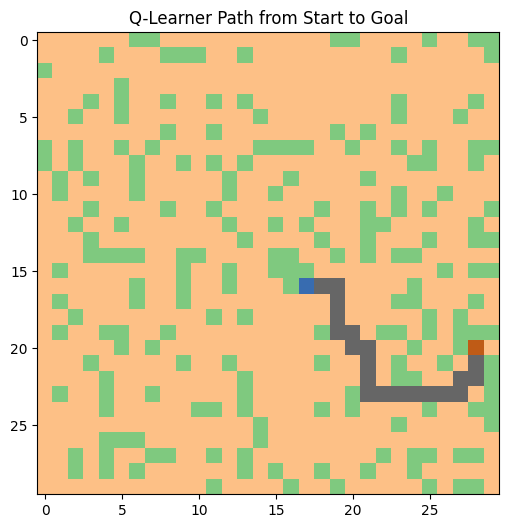

Blue = Start, Red = Goal


In [207]:
# Generate the grid
grid_gen = GridGenerator(30, 200)
grid_gen.generate_grid()
grid_gen.generate_states()
# grid_gen.print_grid()

start = tuple(np.argwhere(grid_gen.grid == 1)[0])
goal = tuple(np.argwhere(grid_gen.grid == 2)[0])

# Train Q-Learner
q_learner = QLearner(grid_gen.grid, start, goal, learning_rate=0.1, gamma=0.9, epsilon=0.1)
q_learner.run_q(episodes=1000)

# Plot the path
q_learner.plot_path()
print('Blue = Start, Red = Goal')
